# Reinforcement Learning Notebook
## Introduction to Q-Learning Algorithm
Based on:
* https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/Taxi-v2/Q%20Learning%20with%20OpenAI%20Taxi-v2%20video%20version.ipynb

## n-Chain environment (OpenAI Gym)
Official documentation: https://gym.openai.com/envs/NChain-v0/

This game presents moves along a linear chain of states, with two actions:
* action 0 = move forward along the chain, but get no reward 
* action 1 = move backward to state 0, get small reward

The end of the chain, however, presents a large reward, and by moving 'forward' at the end of the chain this large reward can be repeated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces

import sys
import warnings
import time

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# initialize the nchain environment
env = gym.make('NChain-v0')

In [3]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[0, 1, 1, 0, 1, 1, 1, 1, 1, 1]

In [4]:
# define the class which consists the q-learning algorithm
class QClass(object):
    
    def __init__(self): 
        
        self.env = gym.make('NChain-v0')
        self.env.env.slip = slip
        state = self.env.reset()
        
        # initalize the Q-table
        self.qtable = self.result = np.zeros((self.env.observation_space.n, 
                                              self.env.action_space.n))
        self.epsilon = max_epsilon
        
    # define the q learning algorithm
    def q_learning_algorithm(self, plot = False):
        # create placeholder to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        
        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):    
                # randomly explore and exploit
                if random.uniform(0,1) >= self.epsilon:
                    # exploitation, max value for given state
                    action = np.argmax(self.qtable[state, :])
                else:
                    # exploration, random choice
                    action = self.env.action_space.sample()

                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)

                # update q Table 
                self.qtable[state, action] = self.update_qtable(state, new_state, action, reward)
                
                # assign the new state
                state = new_state
                
                # update the reward
                self.episode_rewards[episode_i] += reward
                
                # check stopping criterion
                if done == True:
                    break
                    
                # stack results
                self.result = np.dstack((self.result, self.qtable))
            
            self.episode_rewards[episode_i] /= step # average the reward
            
            if episode_i % 100 == 0:
                print('episode', episode_i)
                print('-elapsed time [min]: ' , round( (time.time() - start)/60, 1))
            
            # reduce epsilon, for exploration-exploitation tradeoff
            self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode_i)
            self.episode_epsilon[episode_i] = self.epsilon
            
        if plot:
            # plot the results
            self.visualize_results()
            self.visualize_results_all_states()
            self.visualize_episodes()

            
    def update_qtable(self, state, new_state, action, reward):
        # Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        return self.qtable[state,action] + learning_rate * \
                          (reward + gamma * np.max(self.qtable[new_state, :]) - self.qtable[state, action])
            
    def visualize_results(self):
        y_value = self.result.shape[2]
        markers = ['o','v','^','<','>','1','2']
        
        for state in range(self.result.shape[0]):
            c_state = np.random.rand(3)
            plt.figure(figsize=(10, 6))
            plt.title('state ' + str(state))
            for action in range(self.result.shape[1]):
                plt.scatter(x = range(y_value), 
                            y = self.result[state,action,:y_value],
                            c = c_state, 
                            s = 5, 
                            marker=markers[action],
                            label = 'action' + str(action))
            
            plt.xlabel('# of steps')
            plt.ylabel('Q-Values')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.show()
            
    def visualize_results_all_states(self):
        y_value = self.result.shape[2]
        markers = ['o','v','^','<','>','1','2']
        
        plt.figure(figsize=(12, 8))
        plt.title('all states')
        
        for state in range(self.result.shape[0]):
            c_state = np.random.rand(3)
        
            for action in range(self.result.shape[1]):
                plt.scatter(x = range(y_value), 
                            y = self.result[state,action,:y_value], 
                            c = c_state, 
                            s = 5,
                            marker=markers[action],
                            label = 'action' + str(action) + ' state: ' + str(state))
        plt.xlabel('# of steps')
        plt.ylabel('Q-Values')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

        
    def visualize_episodes(self):
        plt.figure(figsize=(10, 6))
        plt.title('Reward over time per episode')
        plt.plot(self.episode_rewards, c = 'm')
        plt.xlabel('# episodes')
        plt.ylabel('Reward')

        plt.figure(figsize=(10, 6))
        plt.title('Exploration parameter epsilon over time')
        plt.plot(self.episode_epsilon, c = 'k')
        plt.xlabel('# episodes')
        plt.ylabel('Epsilon')
    
    def visualize_test_results(self, rewards):
         plt.figure(figsize=(10, 6))
         plt.title('test score over time')
         plt.scatter(x = range(total_test_episodes), 
                     y = rewards, 
                     s = 16)
         plt.xlabel('# test episodes')
         plt.ylabel('Reward')
         plt.show()
            

    def use_q_table(self, plot = False):
        # use q-table to play the game, just use max action at every state
        rewards = []        
        for episode_i in range(total_test_episodes):
            state = self.env.reset()
            done = False
            total_rewards = 0

            if episode_i % 10 == 0:
                print("test_episode ", episode_i)

            for step in range(max_steps):
                # Take the action (index) that have the maximum expected future reward given that state
                action = np.argmax(self.qtable[state,:])
                # Get new_state and reward
                new_state, reward, done, info = self.env.step(action)
                # update reward
                total_rewards += reward
                # assign new state
                state = new_state
        
                # stopping criterion
                if done == True:
                    break
                    
            rewards.append(total_rewards/step)
        self.env.close()
        print ("Score over time: " +  str(sum(rewards)/total_test_episodes))
        # plot the test results
        if plot:
            self.visualize_test_results(rewards)

In [5]:
# training/testing hyperparameters
max_steps = 10
total_episodes = 1000
total_test_episodes = 50

# q-learning parameters
learning_rate = 0.8 
gamma = 0.9 
# gamma = 1, we care about all future rewards equally as the current one  
# gamma = 0, we only care about the current reward)

# exploration parameters
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.0
decay_rate = 0.008 # smaller decay rate, more exploration
slip = 0.0 # probability of slipping

In [6]:
# initalize the q-learning class
qClass = QClass()

In [7]:
# run q learning algorithm
qClass.q_learning_algorithm()

episode 0
-elapsed time [min]:  0.0
episode 100
-elapsed time [min]:  0.0
episode 200
-elapsed time [min]:  0.0
episode 300
-elapsed time [min]:  0.0
episode 400
-elapsed time [min]:  0.0
episode 500
-elapsed time [min]:  0.0
episode 600
-elapsed time [min]:  0.0
episode 700
-elapsed time [min]:  0.0
episode 800
-elapsed time [min]:  0.0
episode 900
-elapsed time [min]:  0.0


In [8]:
# y-axis: state 0 to state 4
# x-axis: action 0 and action 1
# action 0 = move forward, but get no reward (in the last state get large reward)
# action 1 = move backward to state 0, get small reward

# print out ofthe q-table
# higher values mean higher future rewards for this specific action-state pair
qClass.qtable

array([[ 65.61 ,  61.049],
       [ 72.9  ,  61.049],
       [ 81.   ,  61.049],
       [ 90.   ,  61.049],
       [100.   ,  61.049]])

The q-table should have similar values like the following table:

|  ...  | Action 0  | Action 1 | 
| ------------- | ------------- | ------------- |
| state 0 | 65.61  | 61.049  |
| state 1 | 72.9  | 61.049  |
| state 2 | 81.  | 61.049  |
| state 3 | 90.  | 61.049  |
| state 4 | 100.  | 61.049  |

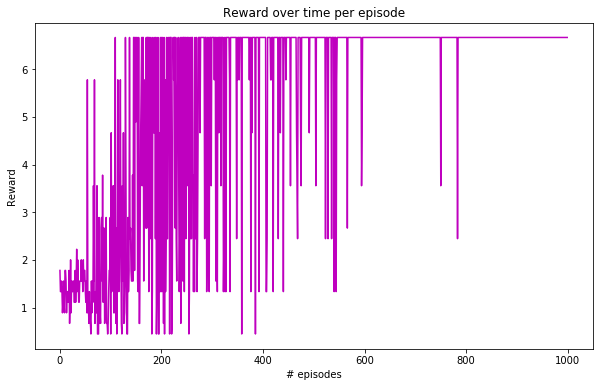

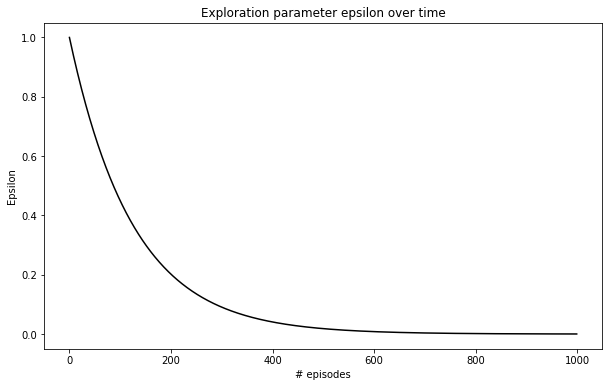

In [9]:
# visualize the q-learning results
qClass.visualize_episodes()

test_episode  0
test_episode  10
test_episode  20
test_episode  30
test_episode  40
Score over time: 6.666666666666669


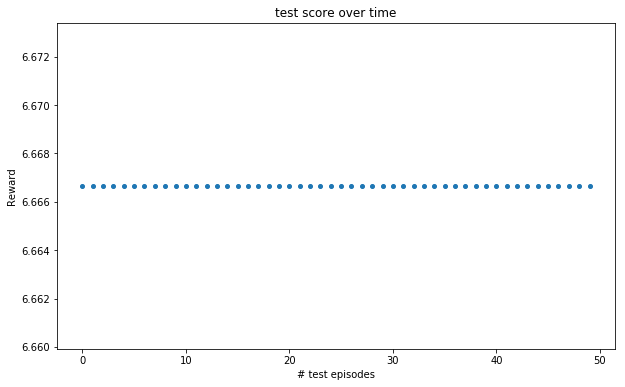

In [10]:
# run the q-learning test
qClass.use_q_table(plot = True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

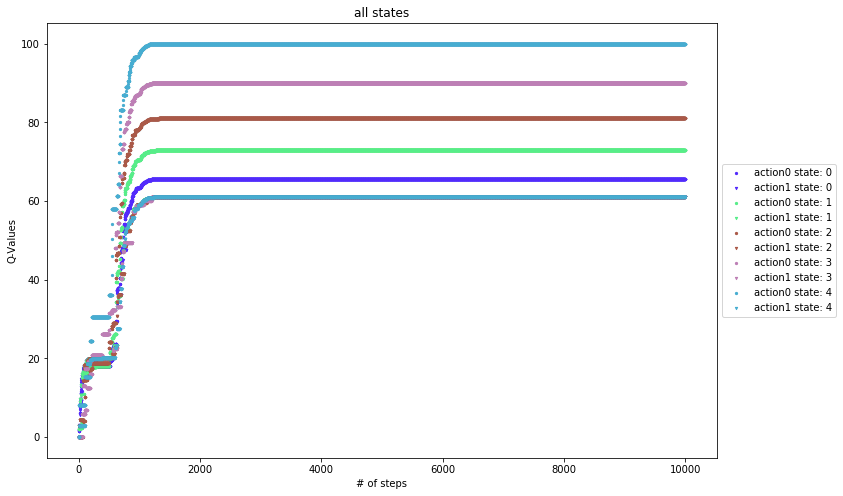

In [11]:
qClass.visualize_results_all_states()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


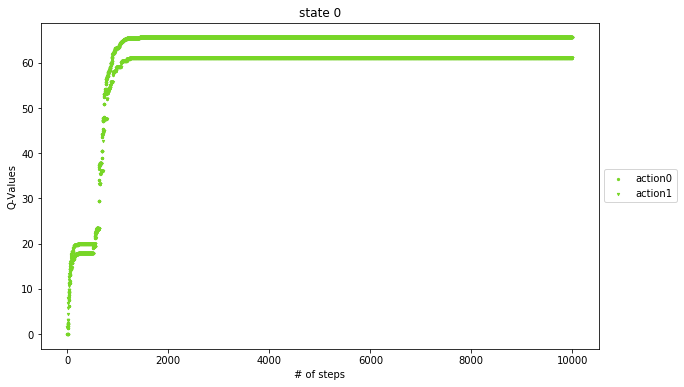

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


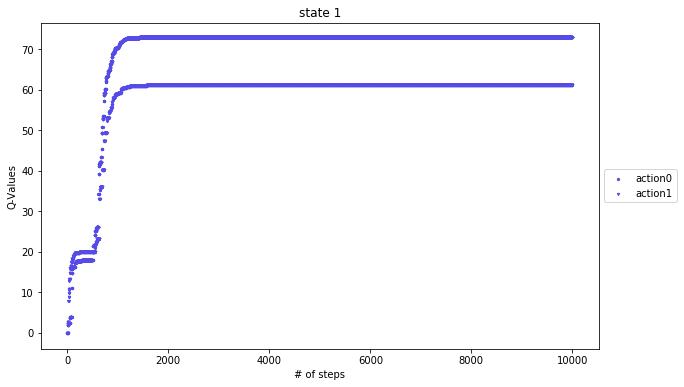

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


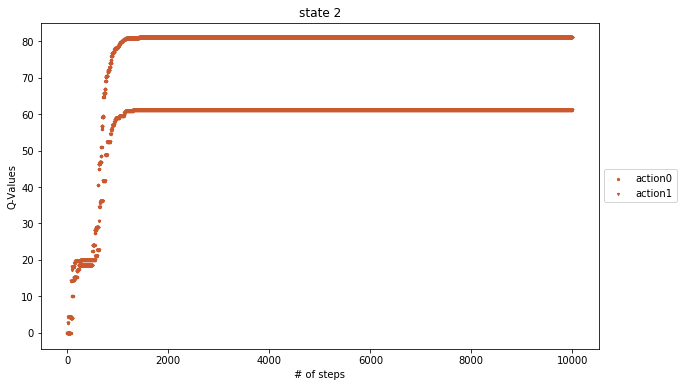

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


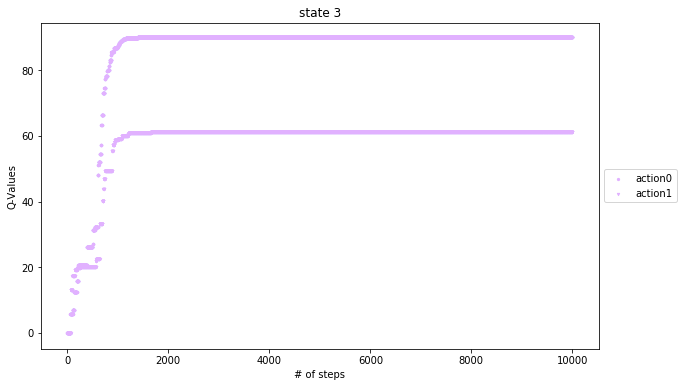

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


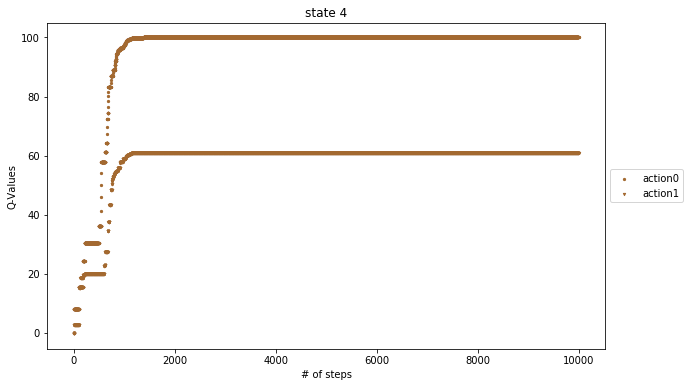

In [12]:
qClass.visualize_results()